In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load the files

In [2]:
import os
print(os.listdir("../project/"))

['application_test.csv', '.DS_Store', 'HomeCredit_columns_description.csv', 'FEcodes.ipynb', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', '.ipynb_checkpoints', 'previous_application.csv', 'bureau_balance.csv']


In [3]:
app_test = pd.read_csv("../project/application_test.csv")
app_train = pd.read_csv("../project/application_train.csv")
bureau = pd.read_csv("../project/bureau.csv")

# Example：Generate new features based on Bureau

In [4]:
#feature1: number of past loans per customer
f1 = bureau[['SK_ID_CURR', 'DAYS_CREDIT']].groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT'].count().reset_index().rename(index = str, columns = {'DAYS_CREDIT': 'BUREAU_LOAN_COUNT'})

In [5]:
#feature2: number of types of past loans per customer
f2 = bureau[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(index=str, columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})
f1 = f1.merge(f2, on = ['SK_ID_CURR'], how = 'left')

In [6]:
#feature3: average number of past loans per type per customer
f1['AVERAGE_LOAN_TYPE'] = f1['BUREAU_LOAN_COUNT']/f1['BUREAU_LOAN_TYPES']

In [7]:
#feature4: percentage of active loans 
bur = bureau
bur['CREDIT_ACTIVE_BINARY'] = bur['CREDIT_ACTIVE']
def binary_de(x):
    if x == "Active":
        y = 1
    else:
        y = 0
    return y
bur['CREDIT_ACTIVE_BINARY'] = bur.apply(lambda x:binary_de(x.CREDIT_ACTIVE),axis=1)
f4 = bur.groupby(by = ['SK_ID_CURR'])['CREDIT_ACTIVE_BINARY'].mean().reset_index().rename(index=str, columns={'CREDIT_ACTIVE_BINARY': 'ACTIVE_LOANS_PERCENTAGE'})
f1 = f1.merge(f4, on = ['SK_ID_CURR'], how = 'left')

In [8]:
#feature5:average number of days in which credit expires in future
bur = bureau
bur['CREDIT_ENDDATE_BINARY'] = bur['DAYS_CREDIT_ENDDATE']
def sign_de(x):
    if x>=0:
        y = 1
    else:
        y = 0   
    return y
bur['CREDIT_ENDDATE_BINARY'] = bur.apply(lambda x: sign_de(x.DAYS_CREDIT_ENDDATE), axis = 1)
#take only positive values of  ENDDATE since we are looking at Bureau Credit VALID IN FUTURE 
bur1 = bur[bur['CREDIT_ENDDATE_BINARY'] == 1]
# Create Dummy Column for CREDIT_ENDDATE 
bur1['DAYS_CREDIT_ENDDATE1'] = bur1['DAYS_CREDIT_ENDDATE']
# Groupby Each Customer ID 
f5_ = bur1[['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT_ENDDATE1']].groupby(by = ['SK_ID_CURR'])
# Sort the values of CREDIT_ENDDATE for each customer ID 
f5 = f5_.apply(lambda x: x.sort_values(['DAYS_CREDIT_ENDDATE1'], ascending = True)).reset_index(drop = True)
f5['DAYS_ENDDATE_DIFF'] = f5.groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT_ENDDATE1'].diff()
f5['DAYS_ENDDATE_DIFF'] = f5['DAYS_ENDDATE_DIFF'].fillna(0).astype('uint32')
del f5['DAYS_CREDIT_ENDDATE1'], f5['SK_ID_CURR']
bur = bur.merge(f5, on = ['SK_ID_BUREAU'], how = 'left')
f5 = bur[['SK_ID_CURR', 'DAYS_ENDDATE_DIFF']].groupby(by = ['SK_ID_CURR'])['DAYS_ENDDATE_DIFF'].mean().reset_index().rename( index = str, columns = {'DAYS_ENDDATE_DIFF': 'AVG_ENDDATE_FUTURE'}).fillna(0)
f1 = f1.merge(f5, on = ['SK_ID_CURR'], how = 'left')

In [9]:
#feature 6: debt over credit ratio
bur = bureau
bur['AMT_CREDIT_SUM_DEBT'] = bur['AMT_CREDIT_SUM_DEBT'].fillna(0)
bur['AMT_CREDIT_SUM'] = bur['AMT_CREDIT_SUM'].fillna(0)
f6_1 = bur[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_DEBT': 'TOTAL_CUSTOMER_DEBT'})
f6_2 = bur[['SK_ID_CURR', 'AMT_CREDIT_SUM']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM': 'TOTAL_CUSTOMER_CREDIT'})
bur = bur.merge(f6_1, on = ['SK_ID_CURR'], how = 'left')
bur = bur.merge(f6_2, on = ['SK_ID_CURR'], how = 'left')
f1['DEBT_CREDIT_RATIO'] = bur['TOTAL_CUSTOMER_DEBT']/bur['TOTAL_CUSTOMER_CREDIT']
f1['DEBT_CREDIT_RATIO'] = f1['DEBT_CREDIT_RATIO'].fillna(0)

In [10]:
#feature 7:overdue overdebt ration
bur = bureau
bur['AMT_CREDIT_SUM_DEBT'] = bur['AMT_CREDIT_SUM_DEBT'].fillna(0)
bur['AMT_CREDIT_SUM_OVERDUE'] = bur['AMT_CREDIT_SUM_OVERDUE'].fillna(0)
f7_1 = bur[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_DEBT': 'TOTAL_CUSTOMER_DEBT'})
f7_2 = bur[['SK_ID_CURR', 'AMT_CREDIT_SUM_OVERDUE']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_OVERDUE'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_OVERDUE': 'TOTAL_CUSTOMER_OVERDUE'})
bur = bur.merge(f7_1, on = ['SK_ID_CURR'], how = 'left')
bur = bur.merge(f7_2, on = ['SK_ID_CURR'], how = 'left')
f1['OVERDUE_DEBT_RATIO'] = bur['TOTAL_CUSTOMER_OVERDUE']/bur['TOTAL_CUSTOMER_DEBT']
f1['OVERDUE_DEBT_RATIO'] = f1['OVERDUE_DEBT_RATIO'].fillna(0)

In [11]:
#feature 8: average number of loans prolonged
bur = bureau
bur['CNT_CREDIT_PROLONG'] = bur['CNT_CREDIT_PROLONG'].fillna(0)
f8 = bur[['SK_ID_CURR', 'CNT_CREDIT_PROLONG']].groupby(by = ['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index().rename( index = str, columns = { 'CNT_CREDIT_PROLONG': 'AVG_CREDITDAYS_PROLONGED'})
f1 = f1.merge(f8, on = ['SK_ID_CURR'], how = 'left')

## f1 contains SK_ID_CURR and 8 new features generated from bureau.csv

# Exploratory Data Analysis

## overall visualization

It shows data imbalance
(307511, 122)
(48744, 121)


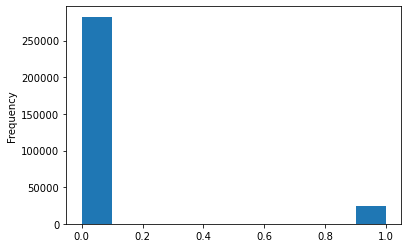

In [12]:
app_train['TARGET'].astype(int).plot.hist()
print("It shows data imbalance")
app_train.dtypes.value_counts()
print(app_train.shape)
print(app_test.shape)

## missing value visualization

In [13]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
missing_values = missing_values_table(app_train)
missing_values

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


In [14]:
#use Label Encoding for categorical variables with only 2 categories 
#One-Hot Encoding for categorical variables with more than 2 categories
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [15]:
from sklearn.preprocessing import LabelEncoder

lel = LabelEncoder()
for col in app_train:
     if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            lel.fit(app_train[col])
            app_train[col] = lel.transform(app_train[col])
            app_test[col] = lel.transform(app_test[col])

In [16]:
#one-hot
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [17]:
#feature intersection between test and train
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels
print(app_train.shape)
print(app_test.shape)

(307511, 240)
(48744, 239)


In [18]:
#anomalies
for col in app_train:
    print(app_train[col].describe())

count    307511.000000
mean     278180.518577
std      102790.175348
min      100002.000000
25%      189145.500000
50%      278202.000000
75%      367142.500000
max      456255.000000
Name: SK_ID_CURR, dtype: float64
count    307511.000000
mean          0.095213
std           0.293509
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: NAME_CONTRACT_TYPE, dtype: float64
count    307511.000000
mean          0.340108
std           0.473746
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: FLAG_OWN_CAR, dtype: float64
count    307511.000000
mean          0.693673
std           0.460968
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: FLAG_OWN_REALTY, dtype: float64
count    307511.000000
mean          0.417052
std           0.722121
min           0.000000
25%           0.000000
50

count    157504.000000
mean          0.977065
std           0.064575
min           0.000000
25%           0.976700
50%           0.981600
75%           0.986600
max           1.000000
Name: YEARS_BEGINEXPLUATATION_MODE, dtype: float64
count    103023.000000
mean          0.759637
std           0.110111
min           0.000000
25%           0.699400
50%           0.764800
75%           0.823600
max           1.000000
Name: YEARS_BUILD_MODE, dtype: float64
count    92646.000000
mean         0.042553
std          0.074445
min          0.000000
25%          0.007200
50%          0.019000
75%          0.049000
max          1.000000
Name: COMMONAREA_MODE, dtype: float64
count    143620.000000
mean          0.074490
std           0.132256
min           0.000000
25%           0.000000
50%           0.000000
75%           0.120800
max           1.000000
Name: ELEVATORS_MODE, dtype: float64
count    152683.000000
mean          0.145193
std           0.100977
min           0.000000
25%           0

count    265992.000000
mean          0.007000
std           0.110757
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.000000
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: float64
count    265992.000000
mean          0.034362
std           0.204685
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: float64
count    265992.000000
mean          0.267395
std           0.916002
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          27.000000
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: float64
count    265992.000000
mean          0.265474
std           0.794056
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         261.000000
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64
count    265992.000000
mean          1.899974
std           1.869295
mi

count    307511.000000
mean          0.104393
std           0.305770
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: OCCUPATION_TYPE_Sales staff, dtype: float64
count    307511.000000
mean          0.004244
std           0.065006
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: OCCUPATION_TYPE_Secretaries, dtype: float64
count    307511.000000
mean          0.021856
std           0.146214
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: OCCUPATION_TYPE_Security staff, dtype: float64
count    307511.000000
mean          0.004384
std           0.066063
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: OCCUPATION_TYPE_Waiters/barmen staff, dtype: float64
count    307511.000000
mean          0.163695
std   

count    307511.000000
mean          0.003860
std           0.062009
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ORGANIZATION_TYPE_Transport: type 3, dtype: float64
count    307511.000000
mean          0.017554
std           0.131323
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ORGANIZATION_TYPE_Transport: type 4, dtype: float64
count    307511.000000
mean          0.004315
std           0.065549
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ORGANIZATION_TYPE_University, dtype: float64
count    307511.000000
mean          0.180072
std           0.384248
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ORGANIZATION_TYPE_XNA, dtype: float64
count    307511.000000
mean          0.018494
std    

In [19]:
a = ['DEF_60_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE',
   'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'TOTALAREA_MODE',
    'FLAG_OWN_REALTY']

In [20]:
for i in a:
    anom = app_train[app_train[i] == max(app_train[i])]
    non_anom = app_train[app_train[i] != max(app_train[i])]
    print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
    print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
    print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.07% of loans
The anomalies default on 0.00% of loans
There are 1 anomalous days of employment
The non-anomalies default on 8.07% of loans
The anomalies default on 0.00% of loans
There are 1 anomalous days of employment
The non-anomalies default on 8.07% of loans
The anomalies default on 0.00% of loans
There are 1 anomalous days of employment
The non-anomalies default on 8.07% of loans
The anomalies default on 0.00% of loans
There are 1 anomalous days of employment
The non-anomalies default on 8.07% of loans
The anomalies default on 7.10% of loans
There are 155 anomalous days of employment
The non-anomalies default on 8.32% of loans
The anomalies default on 7.96% of loans
There are 213312 anomalous days of employment


In [21]:
#anomaly treatment example:days employed&flag_own_reality: substitute anomaly with na
anom = app_train[app_train['DAYS_EMPLOYED'] == max(app_train['DAYS_EMPLOYED'])]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != max(app_train['DAYS_EMPLOYED'])]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))
app_train['DAYS_EMPLOYED'].replace({max(app_train['DAYS_EMPLOYED']): np.nan}, inplace = True)
                                

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


In [22]:
app_train_ = app_train.merge(f1, on = ['SK_ID_CURR'], how = 'left')
app_test_ = app_test.merge(f1, on = ['SK_ID_CURR'], how = 'left')
correlations = app_train_.corr()['TARGET'].sort_values()
correlations

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
                                          ...   
REGION_RATING_CLIENT_W_CITY             0.060893
DAYS_EMPLOYED                           0.074958
ACTIVE_LOANS_PERCENTAGE                 0.077356
DAYS_BIRTH                              0.078239
TARGET                                  1.000000
Name: TARGET, Length: 248, dtype: float64

In [23]:
correlations[-10:]

DAYS_ID_PUBLISH                0.051457
CODE_GENDER_M                  0.054713
DAYS_LAST_PHONE_CHANGE         0.055218
NAME_INCOME_TYPE_Working       0.057481
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
ACTIVE_LOANS_PERCENTAGE        0.077356
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

In [24]:
Data_corr=app_train_.corr()

In [25]:
Data_corr

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,EMERGENCYSTATE_MODE_Yes,TARGET,BUREAU_LOAN_COUNT,BUREAU_LOAN_TYPES,AVERAGE_LOAN_TYPE,ACTIVE_LOANS_PERCENTAGE,AVG_ENDDATE_FUTURE,DEBT_CREDIT_RATIO,OVERDUE_DEBT_RATIO,AVG_CREDITDAYS_PROLONGED
SK_ID_CURR,1.000000,0.001654,0.001216,0.000703,-0.001129,-0.001820,-0.000343,-0.000433,-0.000232,0.000849,...,0.002549,-0.002108,0.002577,0.003714,0.001567,0.001229,0.003591,-0.000700,-0.003213,0.000629
NAME_CONTRACT_TYPE,0.001654,1.000000,0.004022,0.067177,0.029998,-0.003531,-0.221648,-0.241544,-0.185850,0.026867,...,-0.000339,-0.030896,-0.036148,-0.012714,-0.038311,0.032164,0.006595,0.000064,-0.000929,0.011705
FLAG_OWN_CAR,0.001216,0.004022,1.000000,-0.002817,0.102023,0.083383,0.116225,0.141588,0.120310,0.041314,...,-0.007584,-0.021851,0.038533,0.134198,-0.015549,-0.000078,0.021626,0.000909,-0.000985,0.003919
FLAG_OWN_REALTY,0.000703,0.067177,-0.002817,1.000000,-0.002366,0.002934,-0.039270,-0.005225,-0.045537,0.015175,...,-0.008535,-0.006148,0.010215,-0.004565,0.013872,-0.009996,-0.005474,0.001374,-0.002202,-0.004970
CNT_CHILDREN,-0.001129,0.029998,0.102023,-0.002366,1.000000,0.012882,0.002145,0.021374,-0.001827,-0.025573,...,0.004525,0.019187,0.002868,0.047278,-0.017609,0.013221,0.018778,0.000713,0.001238,-0.001962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACTIVE_LOANS_PERCENTAGE,0.001229,0.032164,-0.000078,-0.009996,0.013221,0.016527,-0.021280,-0.037859,-0.026544,0.015857,...,0.000262,0.077356,-0.177704,0.047431,-0.241496,1.000000,0.093512,0.000830,-0.000837,0.045785
AVG_ENDDATE_FUTURE,0.003591,0.006595,0.021626,-0.005474,0.018778,0.025797,0.015594,0.016036,0.016092,0.023225,...,-0.001411,0.023272,0.186751,0.236237,0.091023,0.093512,1.000000,-0.003099,-0.000595,0.061458
DEBT_CREDIT_RATIO,-0.000700,0.000064,0.000909,0.001374,0.000713,0.001206,-0.001404,-0.000114,-0.002361,-0.001846,...,-0.000089,0.002882,-0.000210,0.000189,-0.000703,0.000830,-0.003099,1.000000,-0.005143,-0.002284
OVERDUE_DEBT_RATIO,-0.003213,-0.000929,-0.000985,-0.002202,0.001238,0.000349,0.000276,0.000452,0.000301,-0.002182,...,-0.000061,-0.000774,-0.001228,-0.001745,-0.000345,-0.000837,-0.000595,-0.005143,1.000000,-0.000308


In [33]:
poly_features_train = app_train_[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','ACTIVE_LOANS_PERCENTAGE', 'DAYS_EMPLOYED','TARGET']]
poly_features_test = app_test_[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','ACTIVE_LOANS_PERCENTAGE', 'DAYS_EMPLOYED']]

Text(0.5, 1.0, 'Correlation Heatmap')

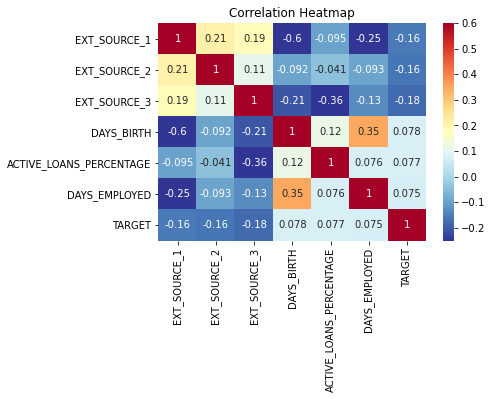

In [34]:
import seaborn as sns
poly_corr=poly_features_train.corr()
sns.heatmap(poly_corr, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

In [35]:
from sklearn.impute import SimpleImputer
#misvalue
imputer = SimpleImputer(strategy = 'median')
poly_target = poly_features_train['TARGET']
poly_features_train = poly_features_train.drop(columns = ['TARGET'])
#misvalue
poly_features_train = imputer.fit_transform(poly_features_train)
poly_features_test = imputer.transform(poly_features_test)
from sklearn.preprocessing import PolynomialFeatures
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 2)
#####这个degree可更改

In [36]:
poly_transformer.fit(poly_features_train)
# Transform the features
poly_features_train = poly_transformer.transform(poly_features_train)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features_train.shape)

Polynomial Features shape:  (307511, 28)


In [37]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','ACTIVE_LOANS_PERCENTAGE', 'DAYS_EMPLOYED'])

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'ACTIVE_LOANS_PERCENTAGE',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_1 ACTIVE_LOANS_PERCENTAGE',
 'EXT_SOURCE_1 DAYS_EMPLOYED',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_2 ACTIVE_LOANS_PERCENTAGE',
 'EXT_SOURCE_2 DAYS_EMPLOYED',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_3 ACTIVE_LOANS_PERCENTAGE',
 'EXT_SOURCE_3 DAYS_EMPLOYED',
 'DAYS_BIRTH^2',
 'DAYS_BIRTH ACTIVE_LOANS_PERCENTAGE',
 'DAYS_BIRTH DAYS_EMPLOYED',
 'ACTIVE_LOANS_PERCENTAGE^2',
 'ACTIVE_LOANS_PERCENTAGE DAYS_EMPLOYED',
 'DAYS_EMPLOYED^2']

In [45]:
pd.DataFrame(poly_features_train[:,1:]).to_csv("train_features.csv")
pd.DataFrame(app_test['TARGET']).to_csv("test_label.csv")
app_train_.to_csv("train.csv")
app_test_.to_csv("test.csv")